In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import yaml
import igraph
from collections import Counter
import networkx as nx
from helpers.linkage import *
from helpers.afa import adaptive_filter
from helpers.visuals import add_cabinet_periods
from helpers import metrics as mc
import seaborn as sns
from helpers.networks import *
import helpers.linkage as lkg
from helpers import style 
from helpers.infodynamics import kld
from networkx.algorithms.community import quality
from networkx.algorithms.assortativity import average_degree_connectivity,average_neighbor_degree
import networkx.algorithms.community as nx_comm
import netrd
from cdlib import algorithms, evaluation
import dynetx as dn
from cdlib import TemporalClustering
from networkx.generators.community import LFR_benchmark_graph
style.load_style()


# https://github.com/sna-unipi/SNA_lectures_notebooks/blob/main/Chapter%2011%20-%20Dynamic%20Community%20Discovery.ipynb

Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool', 'karateclub', 'wurlitzer', 'leidenalg', 'infomap'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'karateclub', 'ASLPAw'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'leidenalg', 'infomap', 'wurlitzer'}


In [2]:
dists = pd.read_csv('/home/rb/Documents/Data/models/lda/full-postwar/dists-speech-bound-250',sep='\t')
data = pd.read_csv('/home/rb/Documents/Data/models/lda/full-postwar/data-speech-level-full.tsv',sep='\t')   
keys = pd.read_csv('/home/rb/Documents/Data/models/lda/full-postwar/keys-speech-bound-250',sep='\t')
labels = dict(zip(keys.index,keys.label))
labels_reverse =dict(zip(labels.values(),labels.keys()))

In [3]:
dists.index = pd.to_datetime(data.date,infer_datetime_format=True)
dists = {q:_.to_numpy() for q,_ in dists.groupby(dists.index.to_period('Q')) if len(_) > 100}
timestamps = sorted(list(set(dists.keys())))
del data

In [4]:
networks = []

for c,date in tqdm(enumerate(timestamps)):
    theta = dists[date]
    theta = mutual_information(theta, topn=None)[0]
    edf = flatten_mi_array(theta)
    edf.columns = ['source','target','w']
    edf = edf[edf.w > 0]
    g = nx.from_pandas_edgelist(df=edf,source='source',target='target', edge_key='weight')
    networks.append(g)

171it [01:43,  1.65it/s]


In [5]:
tc = TemporalClustering()

for c,g in tqdm(enumerate(networks)):
    coms = algorithms.louvain(g)  # here any CDlib algorithm can be applied
    tc.add_clustering(coms, timestamps[c])

171it [00:28,  6.09it/s]


In [6]:
jaccard = lambda x, y:  len(set(x) & set(y)) / len(set(x) | set(y))
matches = tc.community_matching(jaccard, two_sided=True)    

In [7]:
ts_eval = pd.DataFrame(tc.clustering_stability_trend(method=evaluation.nf1),index=timestamps[1:])
ts_eval['afa'] = ts_eval[[0]].apply(adaptive_filter)

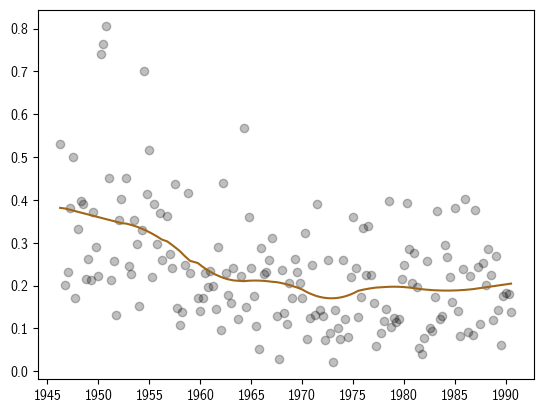

In [8]:
fig,ax = plt.subplots()

ax.scatter(ts_eval.index.to_timestamp(),ts_eval[0],color='black',alpha=.25)
ax.plot(ts_eval.index.to_timestamp(),ts_eval['afa'])

In [9]:
com_polytree = tc.lifecycle_polytree(jaccard, two_sided=False)

In [18]:
tc.get_clustering_at(time=[t for t in timestamps if t.year == 1986 and t.quarter == 1][0])

In [16]:
[(s,t) for s,t in com_polytree.edges if s[:4] == '1986']

[('1986Q1_2', '1986Q2_0'),
 ('1986Q1_1', '1986Q2_4'),
 ('1986Q1_0', '1986Q2_0'),
 ('1986Q1_3', '1986Q2_1'),
 ('1986Q2_0', '1986Q3_3'),
 ('1986Q2_4', '1986Q3_1'),
 ('1986Q2_1', '1986Q3_0'),
 ('1986Q1_4', '1986Q2_1'),
 ('1986Q3_3', '1986Q4_2'),
 ('1986Q3_0', '1986Q4_0'),
 ('1986Q2_2', '1986Q3_2'),
 ('1986Q3_2', '1986Q4_4'),
 ('1986Q2_3', '1986Q3_4'),
 ('1986Q3_4', '1986Q4_0'),
 ('1986Q3_1', '1986Q4_4'),
 ('1986Q2_5', '1986Q3_4'),
 ('1986Q4_0', '1987Q1_0'),
 ('1986Q4_4', '1987Q1_3'),
 ('1986Q4_2', '1987Q1_4'),
 ('1986Q3_5', '1986Q4_1'),
 ('1986Q4_1', '1987Q1_1'),
 ('1986Q4_3', '1987Q1_2')]

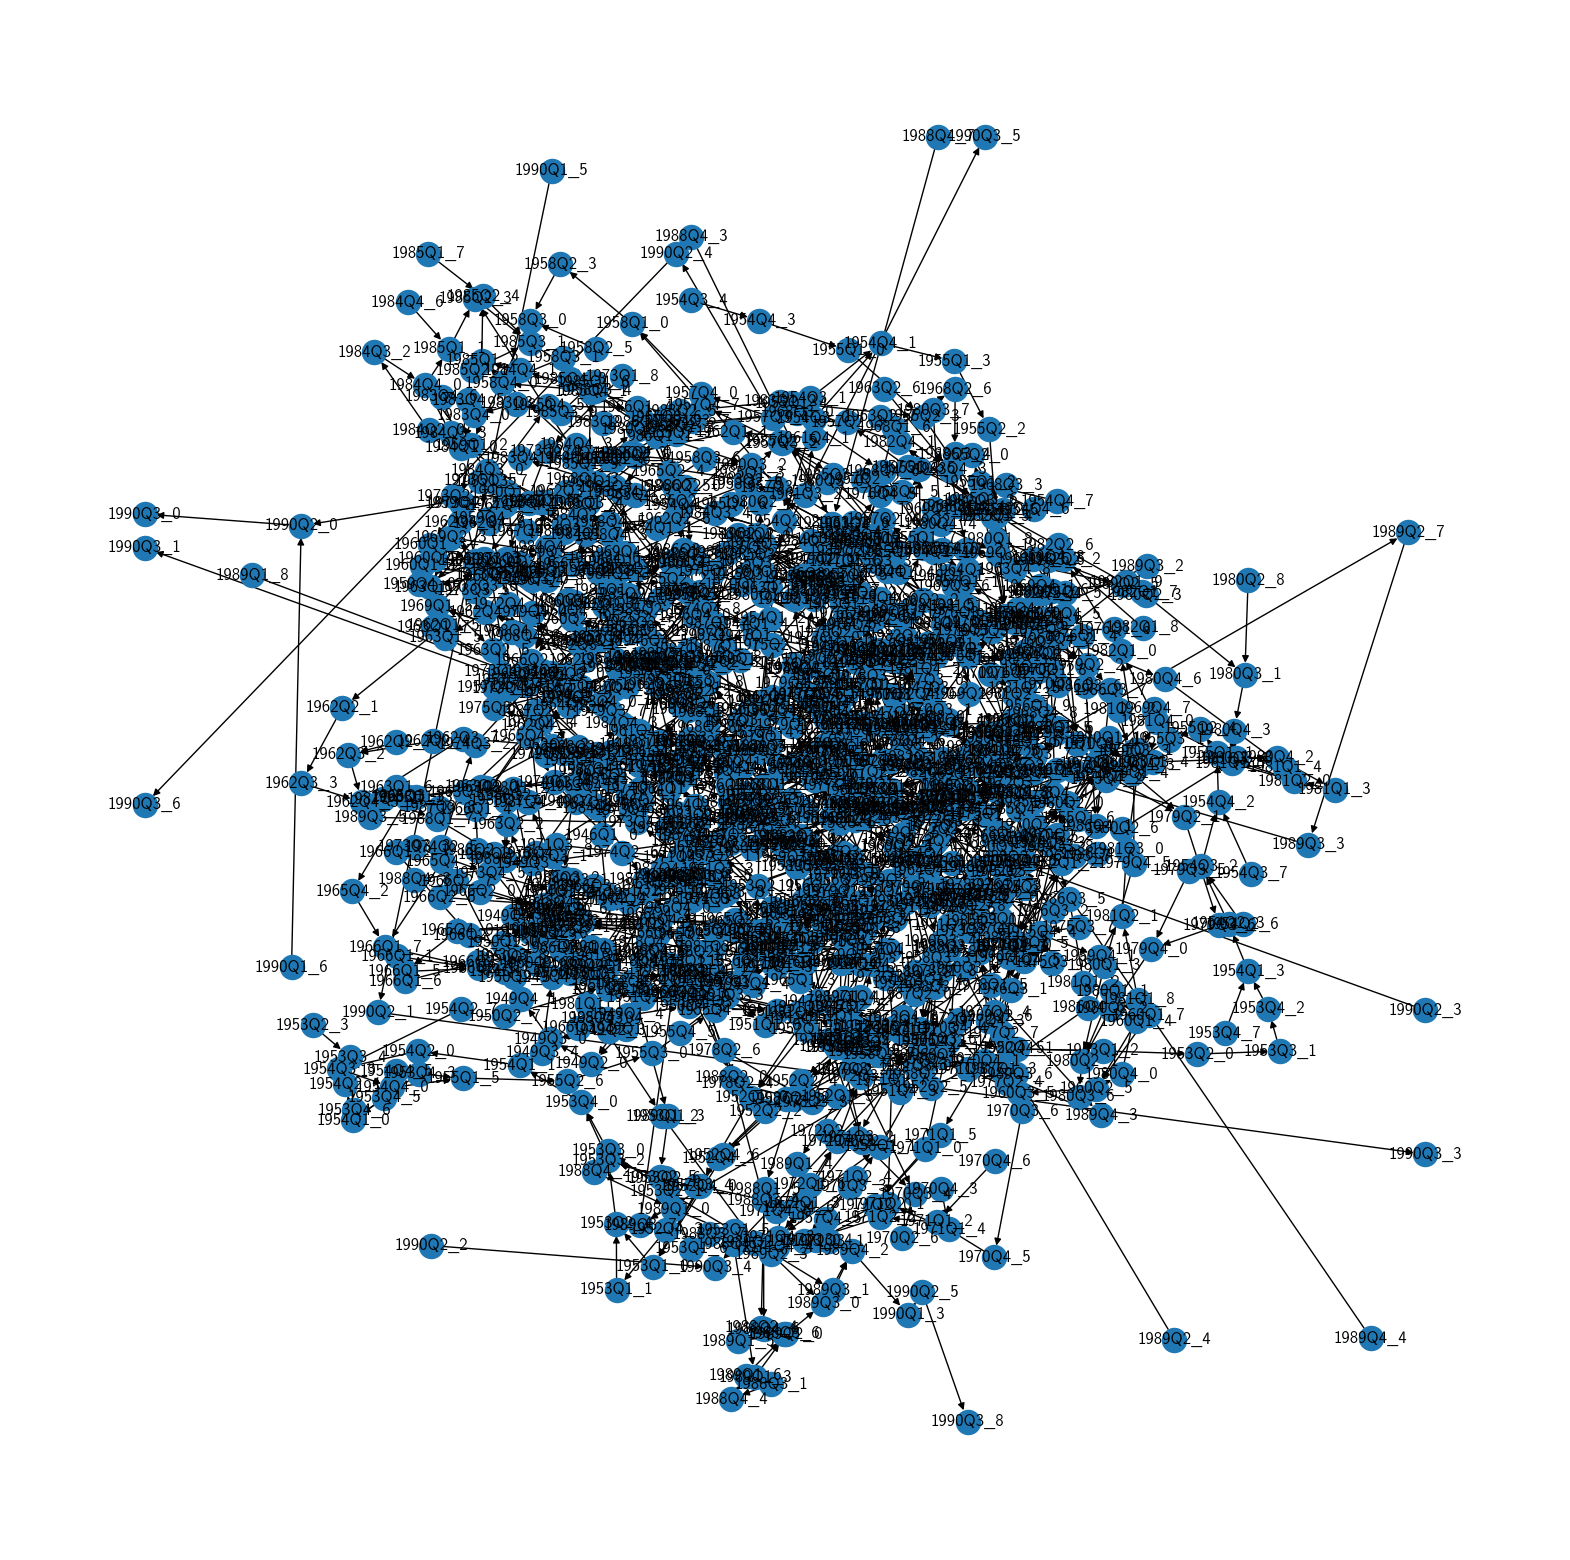

In [70]:
fig,ax = plt.subplots(1,1,figsize=(20,20))
for nodes in nx.weakly_connected_components(com_polytree):
    sub =  com_polytree.subgraph(nodes)
    nx.draw(sub, pos=nx.spring_layout(sub), with_labels=True,ax=ax) 